In [1]:
import pandas as pd
import numpy as np

In [24]:
df = pd.read_csv(r'C:\Users\Jason\Desktop\MATH3790 Midterm\M3790_W01_Midterm_Shiyu_Jiang\Growth rates of personal consumption and personal income in the USA.csv')
df1 = df.copy(deep=True)
df.head(5)

,Consumption,Income,Production,Savings,Unemployment
0,0.615986,0.972261,-2.452700,4.810312,0.9
1,0.460376,1.169085,-0.551525,7.287992,0.5
2,0.876791,1.553271,-0.358708,7.289013,0.5
3,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1.897371,1.987154,1.909734,3.657771,-0.1


In [25]:
for i in range(len(df)):
    if df.iloc[i, 4] > 0:
        df.iloc[i, 4] = 1
    if df.iloc[i, 4] == 0:
        df.iloc[i, 4] = 0
    if df.iloc[i, 4] < 0:
        df.iloc[i, 4] = -1
df.head(5)

,Consumption,Income,Production,Savings,Unemployment
0,0.615986,0.972261,-2.452700,4.810312,1.0
1,0.460376,1.169085,-0.551525,7.287992,1.0
2,0.876791,1.553271,-0.358708,7.289013,1.0
3,-0.274245,-0.255272,-2.185455,0.985230,1.0
4,1.897371,1.987154,1.909734,3.657771,-1.0


# LSTM

In [26]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

<ipython-input-26-f939ec2835ff>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [10]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

Month=1, Predicted=-0.058187, Expected=-1.000000
Month=2, Predicted=-0.367594, Expected=0.000000
Month=3, Predicted=-0.470116, Expected=-1.000000
Month=4, Predicted=-0.301347, Expected=-1.000000
Month=5, Predicted=-0.024734, Expected=-1.000000
Month=6, Predicted=-0.346978, Expected=-1.000000
Month=7, Predicted=-0.424576, Expected=-1.000000
Month=8, Predicted=-0.461332, Expected=-1.000000
Month=9, Predicted=-0.512139, Expected=0.000000
Month=10, Predicted=-0.397818, Expected=0.000000
Month=11, Predicted=0.135787, Expected=-1.000000
Month=12, Predicted=-0.289938, Expected=0.000000
Test RMSE: 0.682


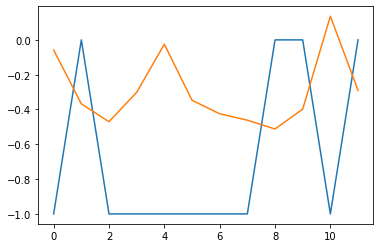

In [11]:
# transform data to be stationary
raw_values = df['Unemployment'].values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Quarter=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

#report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

### Scale the number of employment
base_number = 100

real-time_Number = base_number * (100+unemployment)% 

In [27]:
df1.head(5)

,Consumption,Income,Production,Savings,Unemployment
0,0.615986,0.972261,-2.452700,4.810312,0.9
1,0.460376,1.169085,-0.551525,7.287992,0.5
2,0.876791,1.553271,-0.358708,7.289013,0.5
3,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1.897371,1.987154,1.909734,3.657771,-0.1


In [31]:
df1['Enployment_num'] = 0
base_number = 100
df1.iloc[0, 5] = base_number * (100+0.9)/100
for i in range(len(df1)-1):
    df1.iloc[i+1, 5] = df1.iloc[i, 5] * (100+df1.iloc[i+1, 4])/100

In [38]:
df1.head(5)

,Consumption,Income,Production,Savings,Unemployment,Enployment_num
0,0.615986,0.972261,-2.452700,4.810312,0.9,100.900000
1,0.460376,1.169085,-0.551525,7.287992,0.5,101.404500
2,0.876791,1.553271,-0.358708,7.289013,0.5,101.911523
3,-0.274245,-0.255272,-2.185455,0.985230,0.7,102.624903
4,1.897371,1.987154,1.909734,3.657771,-0.1,102.522278


Quarter=1, Predicted=102.050742, Expected=102.024749
Quarter=2, Predicted=101.925238, Expected=101.820700
Quarter=3, Predicted=101.719949, Expected=101.820700
Quarter=4, Predicted=101.738221, Expected=101.617058
Quarter=5, Predicted=101.541435, Expected=101.413824
Quarter=6, Predicted=101.326825, Expected=101.413824
Quarter=7, Predicted=101.340014, Expected=101.312410
Quarter=8, Predicted=101.263290, Expected=101.109785
Quarter=9, Predicted=101.033928, Expected=101.008676
Quarter=10, Predicted=100.937043, Expected=100.907667
Quarter=11, Predicted=100.849061, Expected=100.806759
Quarter=12, Predicted=100.751466, Expected=100.806759
Quarter=13, Predicted=100.759509, Expected=101.008373
Quarter=14, Predicted=101.026319, Expected=101.109381
Quarter=15, Predicted=101.227760, Expected=101.412709
Quarter=16, Predicted=101.736066, Expected=101.514122
Quarter=17, Predicted=101.821689, Expected=102.021693
Quarter=18, Predicted=102.529343, Expected=102.531801
Quarter=19, Predicted=102.896949, Exp

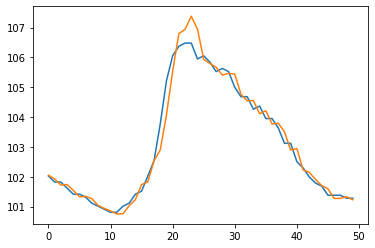

In [39]:
# transform data to be stationary
raw_values = df1['Enployment_num'].values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-50], supervised_values[-50:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Quarter=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

#report performance
rmse = sqrt(mean_squared_error(raw_values[-50:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-50:])
pyplot.plot(predictions)
pyplot.show()